<a href="https://www.kaggle.com/code/merveintepe/speech-model?scriptVersionId=241765697" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Türkçe komut tanıma veri seti
Veri seti toplamda 14 farklı komuttan oluşmaktadır (aç, aşağı, başlat, devam, dur, evet, geri, hayır, ileri, kapa, sağ, sol ve yukarı). Veri seti toplamda 26,485 ses kaydından oluşmaktadır, her ses kaydı tam olarak 1 saniye uzunluğundadır

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/turkish-speech-command-dataset/database/dataBase.xlsx
/kaggle/input/turkish-speech-command-dataset/database/dur/dur_OGLX_UFCJOTZ.wav
/kaggle/input/turkish-speech-command-dataset/database/dur/dur_VJWF_AVSTBDC.wav
/kaggle/input/turkish-speech-command-dataset/database/dur/dur_UXOD_ICMXESG.wav
/kaggle/input/turkish-speech-command-dataset/database/dur/dur_ZWDC_SKXCQBV.wav
/kaggle/input/turkish-speech-command-dataset/database/dur/dur_XCWQ_NGIBYAX.wav
/kaggle/input/turkish-speech-command-dataset/database/dur/dur_VJWF_OQTKGHC.wav
/kaggle/input/turkish-speech-command-dataset/database/dur/dur_WCLX_BXTACKG.wav
/kaggle/input/turkish-speech-command-dataset/database/dur/dur_BLOP_XFGAPRD.wav
/kaggle/input/turkish-speech-command-dataset/database/dur/dur_YMHE_NBGLKWC.wav
/kaggle/input/turkish-speech-command-dataset/database/dur/dur_RWHG_ERNCOGM.wav
/kaggle/input/turkish-speech-command-dataset/database/dur/dur_MOXB_NYJATLB.wav
/kaggle/input/turkish-speech-command-dataset/database/dur/dur_M

İmport Libraries

In [2]:
!pip install -q resampy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 30.8 MB/s eta 0:00:00


In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
import resampy
import librosa
import os
from tqdm import tqdm
from datetime import datetime
from IPython.display import Audio

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Reshape, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings("ignore")

2025-05-25 12:39:53.133563: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748176793.343843      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748176793.405934      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# 1) EDA

veri setinde , verileri tanımak, görselleştirmek, tanımlayıcı istatistiklerine bakmak vb. için keşfedici veri analizi (EDA) yapacağız. Amacımız, veri setini oluşturan değişkenleri anlamaktır.

**Load Data**

In [4]:
speech = pd.read_excel('/kaggle/input/turkish-speech-command-dataset/database/dataBase.xlsx')
df=speech.copy()

In [5]:
df.head()

id person type gender          path
0  ac_UXOD_BTMEAPU   UXOD   ac  ERKEK  dataBase\ac\
1  ac_UXOD_YJTEPUH   UXOD   ac  ERKEK  dataBase\ac\
2  ac_UXOD_CKTQBAP   UXOD   ac  ERKEK  dataBase\ac\
3  ac_UXOD_YCJKIMB   UXOD   ac  ERKEK  dataBase\ac\
4  ac_UXOD_YJKRCPO   UXOD   ac  ERKEK  dataBase\ac\

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26484 entries, 0 to 26483
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      26484 non-null  object
 1   person  26484 non-null  object
 2   type    26484 non-null  object
 3   gender  26484 non-null  object
 4   path    26484 non-null  object
dtypes: object(5)
memory usage: 1.0+ MB


In [7]:
df.describe()

id person   type gender          path
count                26484  26484  26484  26484         26484
unique               26484    257     14      2            14
top     iptal_ENLP_MIZWBOR   YLWN     ac  ERKEK  dataBase\ac\
freq                     1    344   1955  13406          1955

In [8]:
#kaç komut type ı içerdiğini görelim
print(df["type"].value_counts())
print(df["type"].nunique())

type
ac        1955
iptal     1952
sol       1910
yukari    1892
dur       1887
ileri     1886
evet      1885
sag       1883
kapa      1882
devam     1880
geri      1880
baslat    1879
asagi     1870
hayir     1843
Name: count, dtype: int64
14


**Pandas-Profiling**, 
Python programlama dilinde popüler bir veri analizi kütüphanesi olan Pandas ile entegre çalışan bir kütüphanedir. Bu kütüphane, veri setinizin genel özelliklerini anlamak ve hızlı bir şekilde analiz etmek için kullanılır. Pandas-Profiling, temel olarak bir veri çerçevesini alır ve çeşitli istatistikler, grafikler ve özet bilgiler içeren bir rapor oluşturur.

In [9]:
import ydata_profiling
report = ydata_profiling.ProfileReport(df)
report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 5/5 [00:00<00:00, 19.59it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# görselleştirme

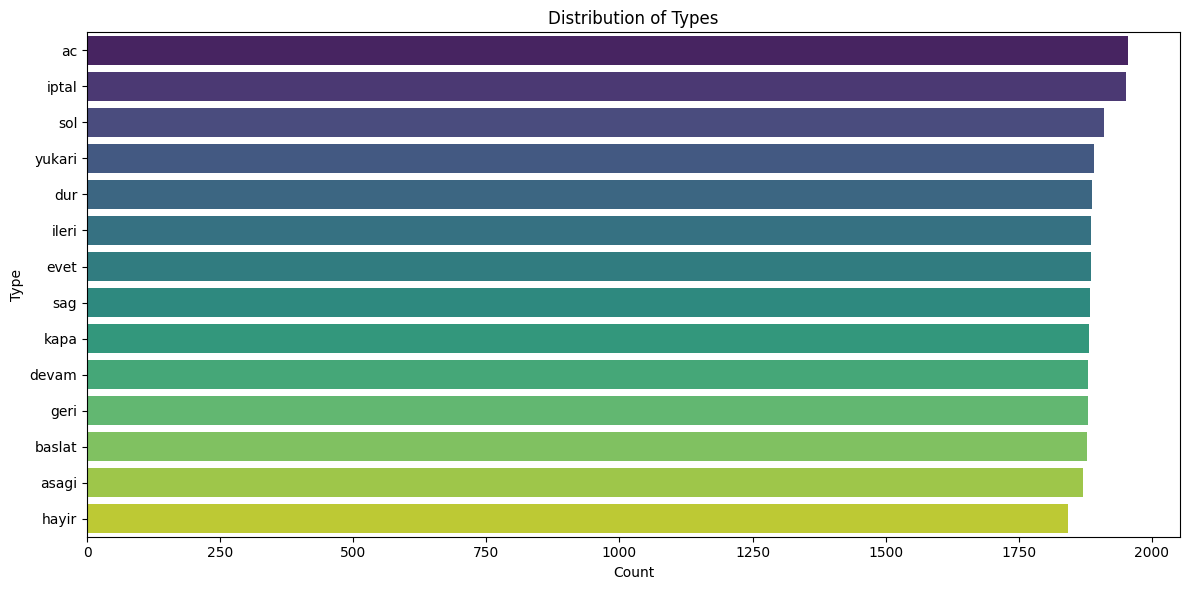

In [10]:
plt.figure(figsize=(12, 6)) 
sns.countplot(data=df, y="type", order = df["type"].value_counts().index, palette="viridis") # Use y="type" for horizontal bars if many unique types
plt.title("Distribution of Types")
plt.xlabel("Count")
plt.ylabel("Type")
plt.tight_layout() 
plt.show()


In [11]:
#kişileri inceleyellim
print(df["person"].value_counts())
print(df["person"].nunique())

person
YLWN    344
DBQP    269
IUBA    267
KRLB    267
WCLX    266
       ... 
TVYM     14
UDOG     14
GWZF     12
CXUL     11
HBXT      6
Name: count, Length: 257, dtype: int64
257


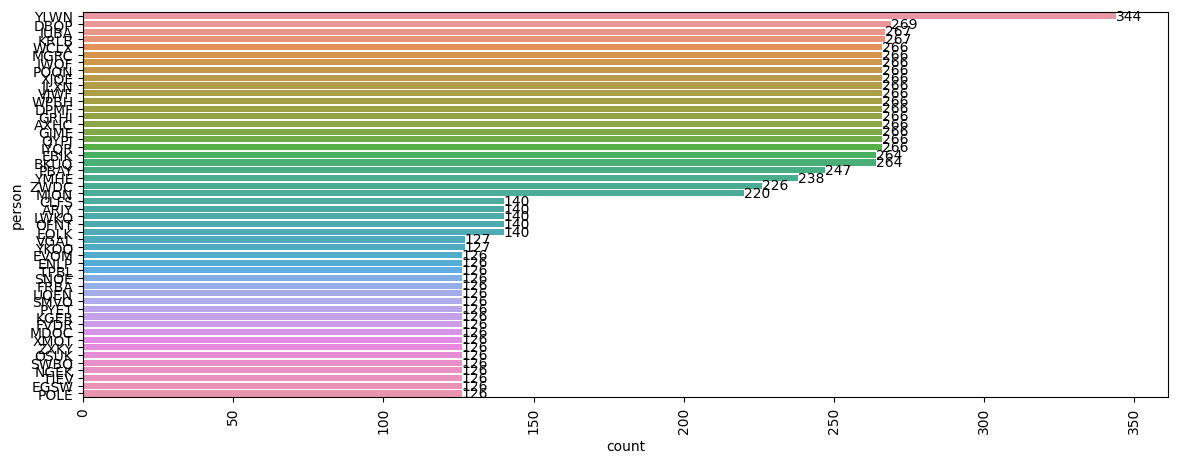

In [12]:
#fazla veri olduğundan ilk 50 yi dahil ettik
plt.figure(figsize=(14, 5))
ax = sns.countplot(data=df, y="person", order=df["person"].value_counts().head(50).index)
ax.bar_label(ax.containers[0])
plt.xticks(rotation=90)
plt.show()

In [13]:
#cinsiyet dağılımına bakalım
df["gender"].value_counts()

gender
ERKEK    13406
KIZ      13078
Name: count, dtype: int64

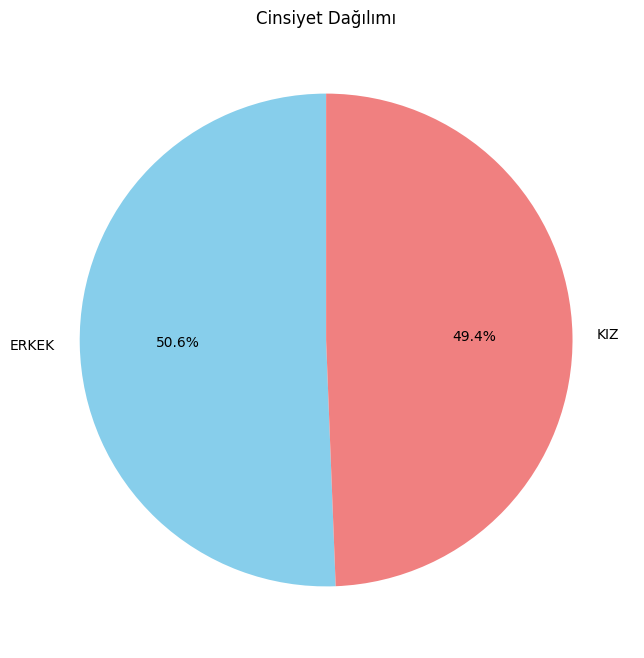

In [14]:
plt.figure(figsize=(8, 8))
df['gender'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightcoral'])
plt.title('Cinsiyet Dağılımı')
plt.ylabel('') 
plt.show()

# VERİ içinden örnek


- librosa.load(random_sample) fonksiyonu, belirtilen dosyayı okur ve
ses sinyalini (`signal`) ve örnekleme hızını (`sampling_rate`) döndürür.
Örnekleme hızı, sesin saniyede kaç örnekle kaydedildiğini gösterir.

-  Audio(data=signal, rate=sampling_rate)
Bu satır, ses sinyalini belirtilen örnekleme hızıyla oynatılabilir hale getiriyor.Bu, yüklenen sesi doğrudan notebook içinde dinlemeyi sağlar (jupyter).


In [15]:
random_sample = "/kaggle/input/turkish-speech-command-dataset/database/dur/dur_MRUS_YSZVWPU.wav"
signal, sampling_rate = librosa.load(random_sample)
Audio(data=signal, rate=sampling_rate)


# **dalga formu**

waveshow() ; ses sinyalini anlamak ve görselleştirmek için kullanılır.
Bu fonksiyonu kullanarak, sesin ne kadar sürede hangi genlik değerlerine ulaştığını, sessiz kısımları, patlamalı (yüksek genlikli) kısımları ve genel ses yapısını görsel olarak inceleyebilirsiniz


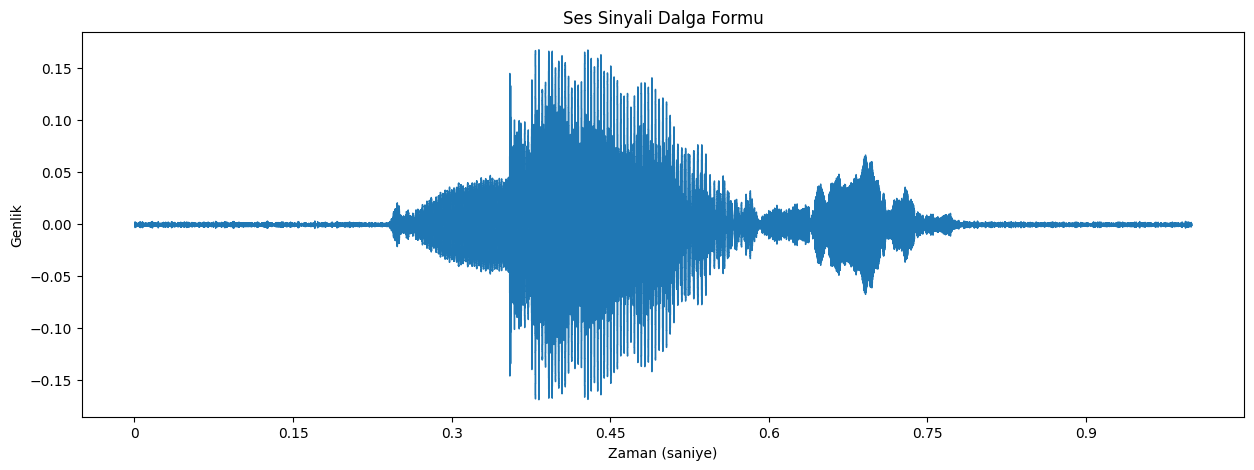

In [16]:
#dalga formu

import librosa.display

plt.figure(figsize=(15, 5))
librosa.display.waveshow(signal,sr=sampling_rate)
plt.title('Ses Sinyali Dalga Formu') # Başlık ekleyelim
plt.xlabel('Zaman (saniye)') # X ekseni etiketi
plt.ylabel('Genlik') # Y ekseni etiketi
plt.show()




# **Spectrogram**

bir ses sinyalinin zamana göre nasıl değiştiğini gösteren bir görselleştirmedir. Temelde, sesin farklı frekans bileşenlerini ve zamanla nasıl değiştiklerini görmemizi sağlar.
Kullanım alanları;
- Ses Analizi: İnsan sesleri, müzik parçaları veya doğal seslerin yapısını incelemek.
- Konuşma İşleme: Kelimelerin ve fonemlerin zaman içindeki frekans dağılımlarını incelemek.
- Ses Tanıma: Müzik türü sınıflandırma, konuşmacı tanıma gibi işlemlerde kullanılır.




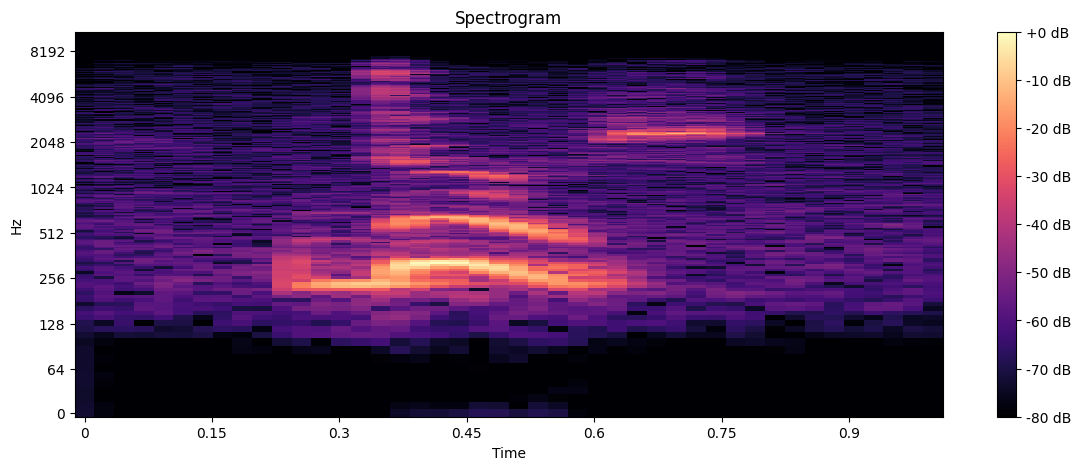

In [17]:
spec = np.abs(librosa.stft(signal)) #ses sinyalini küçük zaman dilimlerine böler, genlik bileşeni alınır
spec = librosa.amplitude_to_db(spec, ref=np.max) #genliği desibel e dönüştürür

plt.figure(figsize=(14, 5))
librosa.display.specshow(data=spec, sr=sampling_rate, x_axis="time", y_axis="log")
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram")
plt.show()

 # Chromagram

bir müzik sinyalinin kromatik ölçek (batı müziğinde kullanılan 12 yarım ton) üzerinden nasıl dağıldığını gösteren bir görselleştirme yöntemidir. Özellikle tonalite analizi ve akort tespiti gibi müzikle ilgili işlemlerde kullanılır.

- Tonalite ve akor tespiti (Şarkının anahtarı nedir?)
- Müzikal benzerlik analizi (İki şarkının tonal olarak benzer olup olmadığını inceleme)
- Melodi ve armoni analizi (Öne çıkan notaların zamana göre değişimini görme)



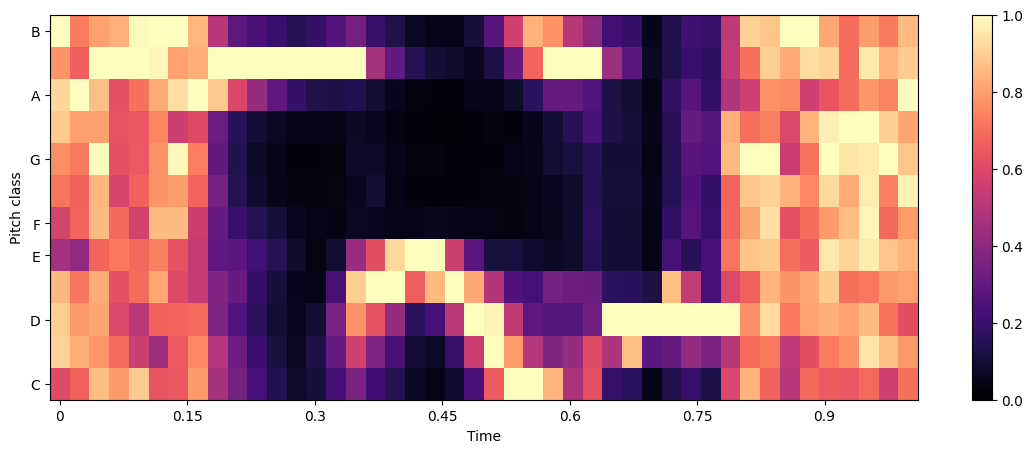

In [18]:
chroma = librosa.feature.chroma_cqt(y=signal, sr=sampling_rate, bins_per_octave=36)

plt.figure(figsize=(14, 5))
librosa.display.specshow(chroma, sr=sampling_rate, x_axis="time", y_axis="chroma", vmin=0, vmax=1)
plt.colorbar()
plt.show()

# ses dosyalarının süreleri

In [19]:
pip install soundfile

Note: you may need to restart the kernel to use updated packages.


In [20]:
import os
import soundfile as sf

durations = []

for root, _, files in os.walk("/kaggle/input/turkish-speech-command-dataset/database/"):
    for file in files:
        if file.endswith(".wav"):
            path = os.path.join(root, file)
            try:
                f = sf.SoundFile(path)
                duration = len(f) / f.samplerate
                durations.append((file, round(duration, 2)))
            except Exception as e:
                print(f"Hata ({e}): {path}")

In [21]:
print(durations)

[('dur_OGLX_UFCJOTZ.wav', 1.0), ('dur_VJWF_AVSTBDC.wav', 1.0), ('dur_UXOD_ICMXESG.wav', 1.0), ('dur_ZWDC_SKXCQBV.wav', 1.0), ('dur_XCWQ_NGIBYAX.wav', 1.0), ('dur_VJWF_OQTKGHC.wav', 1.0), ('dur_WCLX_BXTACKG.wav', 1.0), ('dur_BLOP_XFGAPRD.wav', 1.0), ('dur_YMHE_NBGLKWC.wav', 1.0), ('dur_RWHG_ERNCOGM.wav', 1.0), ('dur_MOXB_NYJATLB.wav', 1.0), ('dur_MDUS_XRIPKDM.wav', 1.0), ('dur_PBUG_UTXGQYN.wav', 1.0), ('dur_ONUZ_DUIMHXL.wav', 1.0), ('dur_UQEN_HIRWSJT.wav', 1.0), ('dur_URLW_JXNCRYB.wav', 1.0), ('dur_URMA_ONXAYVJ.wav', 1.0), ('dur_WLBR_TPIBJYX.wav', 1.0), ('dur_XJQE_TMERUVL.wav', 1.0), ('dur_YLWN_KARIOBG.wav', 1.0), ('dur_YORQ_SKNZBJV.wav', 1.0), ('dur_YLWN_KPSRDQL.wav', 1.0), ('dur_EXYP_CGZIAKV.wav', 1.0), ('dur_MRUS_CQKDRYL.wav', 1.0), ('dur_ZSTK_DLVAOTM.wav', 1.0), ('dur_AXVW_SCNQGOV.wav', 1.0), ('dur_HABV_KDPRQOB.wav', 1.0), ('dur_AXVW_FMOHRCE.wav', 1.0), ('dur_RCQH_YWOJVFT.wav', 1.0), ('dur_NJAR_ZGKRADT.wav', 1.0), ('dur_ZLYH_ZLWKTGP.wav', 1.0), ('dur_RNMT_VPBUFKO.wav', 1.0), ('dur_G

In [22]:
only_durations = [d[1] for d in durations]
print(only_durations)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

In [23]:
unique_count = len(set(only_durations))
print(f"Unique eleman sayısı: {unique_count}")

Unique eleman sayısı: 1


**hepsinin süresi aynı ve 1 dir**

# 2) VERİ KONTROL

# missing value

In [24]:
missing=df.isnull().sum()
print(missing)

id        0
person    0
type      0
gender    0
path      0
dtype: int64


# Reaching Duplicated Observations

In [25]:
duplicated_observations = df[df.duplicated()]
df.duplicated().sum()

0

# 3) VERİ AYIRMA

In [26]:
# Özellik çıkarım fonksiyonu
def extract_features(file_path):
    audio, sr = librosa.load(file_path, duration=3, offset=0.5)
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
    return np.mean(mfccs.T, axis=0)

**n_mfcc için;**
- Müzik Analizi veya Ses Sınıflandırma için genellikle 20-40 MFCC kullanılır. Daha fazla MFCC, sesin detaylarını daha iyi temsil eder ve müzikal frekansları veya ortam seslerini yakalamak için kullanılır


In [27]:
import os
import librosa


# 3. Veri hazırlama
data = []
labels = []
base_path = "/kaggle/input/turkish-speech-command-dataset/database/"

for emotion_label in os.listdir(base_path):
    emotion_folder = os.path.join(base_path, emotion_label)
    if os.path.isdir(emotion_folder):
        for file in os.listdir(emotion_folder):
            if file.endswith(".wav"):
                file_path = os.path.join(emotion_folder, file)
                features = extract_features(file_path)
                data.append(features)
                labels.append(emotion_label)



In [28]:
print(len(data))
print(len(labels))

26484
26484


In [29]:
print(pd.DataFrame(data))

               0           1          2          3          4          5   \
0     -580.198914   77.905685 -12.084397  49.032406 -24.832733  39.334576   
1     -421.938782  103.121429 -20.560472  16.676874 -17.315186   3.597957   
2     -414.437805  120.031197 -49.408218   8.981744  -8.639672  -8.900324   
3     -501.534363   86.982811 -17.883940  34.945011  -8.483347  21.340746   
4     -513.332397   36.750599  -9.923202  12.757755 -12.813217  27.069139   
...           ...         ...        ...        ...        ...        ...   
26479 -508.982239  104.743851 -23.051025  33.870403 -20.879265  10.387632   
26480 -493.053833   99.448418  -1.045274  24.194304 -50.080956  12.309783   
26481 -444.292786   69.992523 -13.218551  31.914370 -28.302797   4.661252   
26482 -451.284271  125.132477 -31.660004  13.687575 -35.474079   5.040925   
26483 -445.211609   72.843201 -60.725391  13.332709 -16.643753  18.248497   

              6          7          8          9   ...        30        31 

In [30]:
print( data[0])       
print( labels[0]) 

[-5.8019891e+02  7.7905685e+01 -1.2084397e+01  4.9032406e+01
 -2.4832733e+01  3.9334576e+01 -4.7532210e+00 -8.0007353e+00
 -7.1810927e+00 -2.2438158e+01 -1.0226824e+01 -1.6273987e+01
 -1.0898437e+01 -8.8173332e+00 -9.2598420e-01 -1.1999706e+01
  3.4721756e+00 -5.8073807e-01 -2.4235857e+00  9.5902367e+00
  1.4358684e+00  5.3525028e+00  6.1114011e+00 -6.9740731e-01
 -3.2048151e+00  3.4478204e+00 -4.4102449e+00 -2.1420047e+00
 -2.0420766e+00 -3.1981459e+00 -2.0476172e+00 -8.2525606e+00
 -3.2836976e+00 -6.8241520e+00 -2.6066697e+00 -4.1429791e+00
 -8.2841215e+00 -3.9211676e+00 -2.1342342e+00 -5.1668656e-01]
dur


In [31]:
print("Bir örnek veri vektörünün uzunluğu:", len(data[0]))

Bir örnek veri vektörünün uzunluğu: 40


In [32]:
data_df = pd.DataFrame({"data":data, "labels":labels})
data_df.head()

data labels
0  [-580.1989, 77.905685, -12.084397, 49.032406, ...    dur
1  [-421.93878, 103.12143, -20.560472, 16.676874,...    dur
2  [-414.4378, 120.0312, -49.40822, 8.981744, -8....    dur
3  [-501.53436, 86.98281, -17.88394, 34.94501, -8...    dur
4  [-513.3324, 36.7506, -9.923202, 12.757755, -12...    dur

In [33]:
num_labels = len(data_df["labels"].unique())
num_labels

14

In [34]:
print(pd.DataFrame(labels))

            0
0         dur
1         dur
2         dur
3         dur
4         dur
...       ...
26479  baslat
26480  baslat
26481  baslat
26482  baslat
26483  baslat

[26484 rows x 1 columns]


In [35]:
X = np.array(data)
y = np.array(labels)

In [36]:
print(type(data))
print(type(X))

<class 'list'>
<class 'numpy.ndarray'>


# LabelEncoder

In [37]:
#Etiketleri encode et (string -> sayısal)
le = LabelEncoder()
y = le.fit_transform(y)

In [38]:
print(y)

[4 4 4 ... 2 2 2]


# 4) MODEL

In [39]:
# 1. Öncelikle veriyi test ve geçici (train+val) olarak ayırma
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 2. Geçici veriyi de train ve validation olarak ayırma 
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

In [40]:
print("X_temp şekli:", X_temp.shape)
print("X_test şekli:", X_test.shape)
print("y_temp şekli:", y_temp.shape)
print("y_test şekli:", y_test.shape)
print("X_train şekli:", X_train.shape)
print("X_val şekli:", X_val.shape)
print("y_train şekli:", y_train.shape)
print("y_val şekli:", y_val.shape)


X_temp şekli: (21187, 40)
X_test şekli: (5297, 40)
y_temp şekli: (21187,)
y_test şekli: (5297,)
X_train şekli: (15890, 40)
X_val şekli: (5297, 40)
y_train şekli: (15890,)
y_val şekli: (5297,)


In [41]:
# 3. Modeli oluştur ve train setiyle eğitme
from lightgbm import LGBMClassifier

model=LGBMClassifier()
model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003322 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 15890, number of used features: 40
[LightGBM] [Info] Start training from score -2.606125
[LightGBM] [Info] Start training from score -2.650577
[LightGBM] [Info] Start training from score -2.646131
[LightGBM] [Info] Start training from score -2.645244
[LightGBM] [Info] Start training from score -2.641704
[LightGBM] [Info] Start training from score -2.642588
[LightGBM] [Info] Start training from score -2.645244
[LightGBM] [Info] Start training from score -2.664940
[LightGBM] [Info] Start training from score -2.641704
[LightGBM] [Info] Start training from score -2.607832
[LightGBM] [Info] Start training from score -2.643472
[LightGBM] [Info] Start training from score -2.644358
[LightGBM] [Info] Start training from score -2.629412
[LightGB

LGBMClassifier()

In [42]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report



# 4. Validation set ile değerlendirme
y_val_pred = model.predict(X_val)
val_acc = accuracy_score(y_val, y_val_pred)
print("Validation Accuracy:", val_acc)
print(classification_report(y_val, y_val_pred))

Validation Accuracy: 0.645648480271852
              precision    recall  f1-score   support

           0       0.84      0.83      0.83       391
           1       0.62      0.57      0.59       374
           2       0.67      0.70      0.68       376
           3       0.66      0.69      0.68       376
           4       0.73      0.72      0.73       378
           5       0.65      0.61      0.63       377
           6       0.52      0.52      0.52       376
           7       0.69      0.67      0.68       368
           8       0.52      0.50      0.51       377
           9       0.60      0.60      0.60       390
          10       0.52      0.55      0.53       376
          11       0.57      0.55      0.56       377
          12       0.85      0.86      0.85       382
          13       0.61      0.66      0.63       379

    accuracy                           0.65      5297
   macro avg       0.65      0.65      0.64      5297
weighted avg       0.65      0.65      0.

Confusion Matrix (Test Set):
 [[324   0  14   0   4  20   2  17   1   7   0   1   1   0]
 [  0 212  23   5  12   6   2   4   3  20   5   5   3  74]
 [  6  16 265   1   5  15   2   3   1  32  14   7   7   2]
 [  1   9   3 260   8   1   1   0   0   4  51  28   8   2]
 [ 16   9   6  11 274  16   5  11   4   7   3   4   6   6]
 [ 19   7  20   1  15 231   9  21  26  15   1   0   1  11]
 [  3   4   0   4   6   8 195  20 109  14   0   0   4   9]
 [ 12   7   8   0  18  12  35 247  10   6   0   1   4   8]
 [  2   4   1   2   9  20  97  19 189   5   1   1   2  25]
 [  2  20  42   7   9  12   9   7   2 233  11   6   9  21]
 [  1   4   4  43   4   1   0   0   0  10 205  98   6   0]
 [  1   0   5  36   2   2   1   0   1  14 101 207   6   1]
 [  1   3   4  18   0   3   5   1   2   3   6   5 328   3]
 [  0  48   3   3   7  10  14   7  17  16   0   2   2 250]]


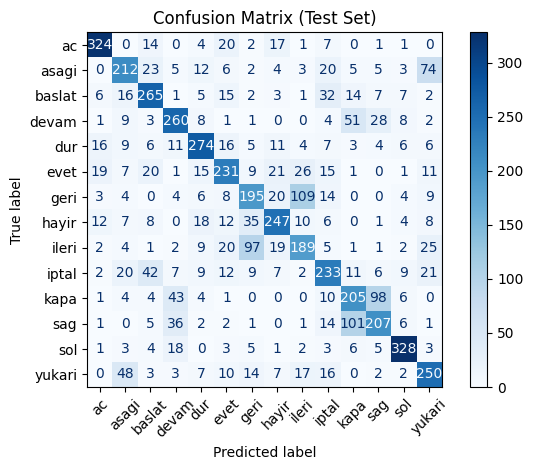

In [43]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


# Confusion matrix oluştur ve yazdır
cm = confusion_matrix(y_val, y_val_pred)
print("Confusion Matrix (Test Set):\n", cm)

# Görselleştir
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)  # le = LabelEncoder
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Test Set)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [44]:
# 5.  test set ile değerlendirme
y_test_pred = model.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", test_acc)
print(classification_report(y_test, y_test_pred))

Test Accuracy: 0.6380970360581462
              precision    recall  f1-score   support

           0       0.84      0.80      0.82       391
           1       0.58      0.49      0.53       374
           2       0.67      0.71      0.69       376
           3       0.71      0.73      0.72       376
           4       0.74      0.72      0.73       377
           5       0.65      0.62      0.64       377
           6       0.51      0.54      0.52       376
           7       0.71      0.71      0.71       369
           8       0.52      0.54      0.53       377
           9       0.53      0.57      0.55       391
          10       0.57      0.55      0.56       376
          11       0.57      0.57      0.57       377
          12       0.83      0.81      0.82       382
          13       0.54      0.57      0.55       378

    accuracy                           0.64      5297
   macro avg       0.64      0.64      0.64      5297
weighted avg       0.64      0.64      0.64   

Confusion Matrix (Test Set):
 [[314   0  15   1  10  14   1  19   3  11   1   0   1   1]
 [  0 183  19   3   9  14   9   1   9  24   3   1   2  97]
 [  7  14 266   1   4  19   0   1   0  45   6   4   6   3]
 [  0   2   3 274  13   0   2   0   2  10  21  36  12   1]
 [ 17   7  13   7 270  12   6  13   7   4   6   4   7   4]
 [ 22   6  22   0  15 233  16  21  11  17   2   1   3   8]
 [  1   3   1   3   6  10 203  21 111   5   0   0   0  12]
 [  9   5   3   3  11  11  25 261  20   9   2   0   3   7]
 [  0   2   0   3   1  12 102  14 204   9   0   0   1  29]
 [  2  23  32  11   8  15   9   8   4 223  13  11  10  22]
 [  1   3  10  32   4   2   1   0   1  15 206  95   6   0]
 [  0   2  10  30   5   3   1   0   0   9  93 215   8   1]
 [  1   1   4  17   2   2   3   3   5  11   9  10 311   3]
 [  1  62   1   3   5   9  23   7  18  25   1   1   5 217]]


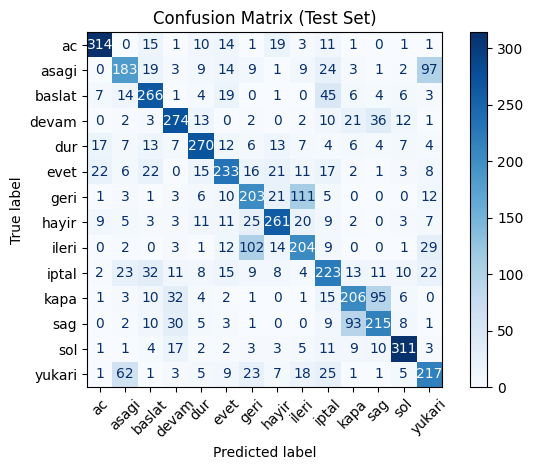

In [45]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


# Confusion matrix oluştur ve yazdır
cm = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix (Test Set):\n", cm)

# Görselleştir
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)  # le = LabelEncoder
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Test Set)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 5) ÖRNEKLER

In [46]:
for idx, label in enumerate(le.classes_):
    print(f"{idx} → {label}")

0 → ac
1 → asagi
2 → baslat
3 → devam
4 → dur
5 → evet
6 → geri
7 → hayir
8 → ileri
9 → iptal
10 → kapa
11 → sag
12 → sol
13 → yukari


# örnek 1

In [47]:
import random

# Örnek sayısı
num_samples = 10

# Test verisinden rastgele indeksler seç
random_indices = random.sample(range(len(X_test)), num_samples)

for idx in random_indices:
    sample = X_test[idx].reshape(1, -1)  # sklearn için 2D array
    true_label = y_test[idx]
    pred_label = model.predict(sample)[0]
    
    print(f"Gerçek: {true_label}  --- Tahmin: {pred_label}")

Gerçek: 13  --- Tahmin: 13
Gerçek: 2  --- Tahmin: 2
Gerçek: 5  --- Tahmin: 5
Gerçek: 0  --- Tahmin: 0
Gerçek: 2  --- Tahmin: 2
Gerçek: 11  --- Tahmin: 11
Gerçek: 5  --- Tahmin: 5
Gerçek: 2  --- Tahmin: 2
Gerçek: 3  --- Tahmin: 3
Gerçek: 10  --- Tahmin: 12


# örnek 2

In [48]:
# 1. Etiket klasörlerinden rastgele bir klasör seç
random_label = random.choice(labels)
folder_path = os.path.join("/kaggle/input/turkish-speech-command-dataset/database/", random_label)

# 2. O klasördeki .wav dosyalarından rastgele birini seç
wav_files = [f for f in os.listdir(folder_path) if f.endswith('.wav')]
random_file = random.choice(wav_files)

file_path = os.path.join(folder_path, random_file)
print(f"Seçilen dosya: {file_path}")

# 3. Ses dosyasını yükle ve MFCC çıkar
audio, sr = librosa.load(file_path, sr=None)
mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
mfcc_scaled = np.mean(mfcc.T, axis=0).reshape(1, -1)

# 4. Modelle tahmin yap
predicted_label = model.predict(mfcc_scaled)[0]

# 5. Sonucu yazdır
print(f"Gerçek etiket: {random_label}")
print(f"Tahmin edilen: {predicted_label}") 

Seçilen dosya: /kaggle/input/turkish-speech-command-dataset/database/ac/ac_PBUG_RHGACUO.wav
Gerçek etiket: ac
Tahmin edilen: 9
